📥 Loading and preprocessing data...
Checking for NaN values in raw data:
NaN in x_accel: 0 NaN values
NaN in y_accel: 0 NaN values
NaN in z_accel: 1 NaN values
NaN detected in segment starting at index 343360
Check for NaN values in X_train: False
Check for NaN values in y_train: False
🧠 Training LSTM model...
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 93s 696ms/step - accuracy: 0.2920 - loss: 1.6425 - val_accuracy: 0.4545 - val_loss: 1.4637
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 85s 683ms/step - accuracy: 0.5005 - loss: 1.2876 - val_accuracy: 0.5830 - val_loss: 1.0471
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 144s 701ms/step - accuracy: 0.6158 - loss: 1.0491 - val_accuracy: 0.7390 - val_loss: 0.8216
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 139s 681ms/step - accuracy: 0.7310 - loss: 0.8834 - val_accuracy: 0.7386 - val_loss: 0.7822
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 139s 654ms/step - accuracy: 0.7376 - loss: 0.7839 - val_accuracy: 0.7723 - val_loss: 0.6982
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 84s 680ms/step - accuracy: 0.7464 - loss: 0.7278 - val_accuracy: 0.7504 - val_loss: 0.6880
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 142s 681ms/step - accuracy: 0.7438 - loss: 0.7031 - val_accuracy: 0.7773 - val_loss: 0.6469
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 84s 680ms/step - accuracy: 0.7694 - loss: 0.6506 -

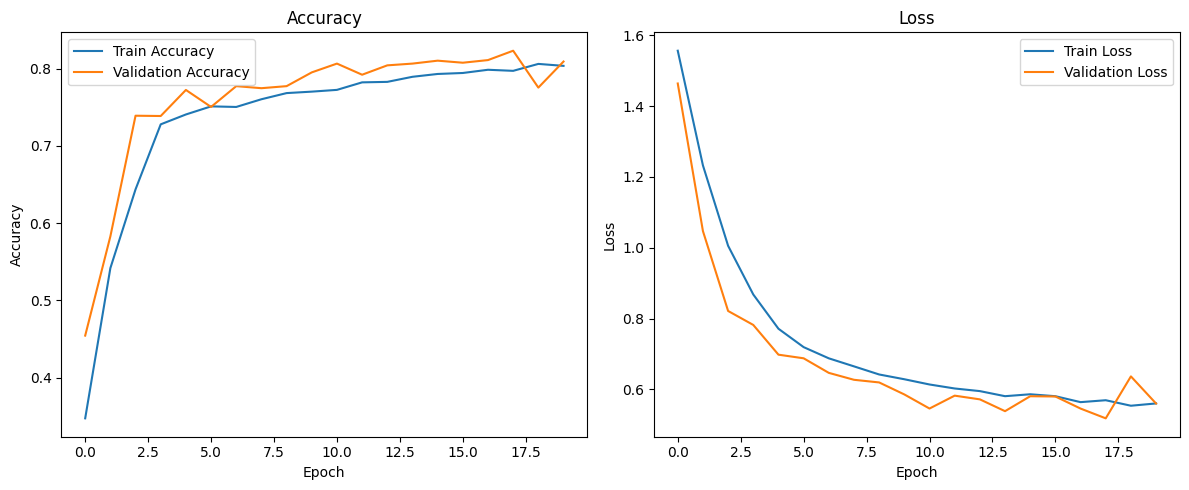


🎯 Final Accuracy Results:
Training Accuracy:       83.46%
Validation Accuracy:     82.31%
Test Accuracy:           83.18%
Total Final Accuracy:    83.17%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step

🧪 Sample Predictions:
True Labels:      ['Walking' 'Walking' 'Downstairs' 'Upstairs' 'Upstairs' 'Jogging'
 'Walking' 'Sitting' 'Standing' 'Downstairs']
Predicted Labels: ['Walking' 'Walking' 'Downstairs' 'Downstairs' 'Downstairs' 'Jogging'
 'Walking' 'Sitting' 'Standing' 'Downstairs']
🏁 Done!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop  # Changed optimizer
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping

# Load WISDM CSV Dataset
def load_wisdm_csv(filepath):
    df = pd.read_csv(filepath)
    df.columns = df.columns.str.strip()  # remove whitespace
    return df[['user', 'activity', 'timestamp', 'x_accel', 'y_accel', 'z_accel']]

# Segment the Data with added checks
def segment_data(df, window_size):
    segments, labels = [], []
    for i in range(0, len(df) - window_size, window_size):
        x = df['x_accel'].values[i:i + window_size]
        y = df['y_accel'].values[i:i + window_size]
        z = df['z_accel'].values[i:i + window_size]
        activity = df['activity'].values[i:i + window_size]

        # Check for NaN values in the segment
        if np.any(np.isnan(x)) or np.any(np.isnan(y)) or np.any(np.isnan(z)):
            print(f"NaN detected in segment starting at index {i}")
            continue  # Skip this segment

        # Ensure all labels in the segment are the same
        if len(set(activity)) == 1:
            segments.append([x, y, z])
            labels.append(activity[0])

    # Convert to numpy arrays
    segments = np.array(segments)
    labels = np.array(labels)

    return segments, labels

# Preprocess with checks in segmentation
def preprocess_data(filepath, window_size):
    df = load_wisdm_csv(filepath)
    print("Checking for NaN values in raw data:")
    print(f"NaN in x_accel: {df['x_accel'].isna().sum()} NaN values")
    print(f"NaN in y_accel: {df['y_accel'].isna().sum()} NaN values")
    print(f"NaN in z_accel: {df['z_accel'].isna().sum()} NaN values")

    segments, labels = segment_data(df, window_size)

    if len(segments) == 0:
        print("No valid segments found. Ensure data is clean and segmentation is correct.")
        return None, None, None, None

    # Normalize accelerometer data (standard scaling)
    scaler = StandardScaler()

    # Flatten the segments to 2D for scaling
    segments = segments.reshape(-1, segments.shape[1] * segments.shape[2])

    # Check for NaN or Infinite values before scaling
    if np.any(np.isnan(segments)) or np.any(np.isinf(segments)):
        print("Data contains NaN or infinite values before scaling.")
        return None, None, None, None

    segments = scaler.fit_transform(segments)

    # Check after scaling
    if np.any(np.isnan(segments)) or np.any(np.isinf(segments)):
        print("Data contains NaN or infinite values after scaling.")
        return None, None, None, None

    # Reshape back to 3D (samples, window_size, features)
    segments = segments.reshape(-1, window_size, 3)

    le = LabelEncoder()
    y = le.fit_transform(labels)
    y = to_categorical(y)

    return segments, y, le, scaler


# LSTM Model with Bidirectional LSTM and Dense Layers
def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
        Dropout(0.5),
        Bidirectional(LSTM(128)),
        Dropout(0.5),
        Dense(64, activation='tanh'),  # Changed activation function
        Dense(32, activation='tanh'),  # Changed activation function
        Dense(num_classes, activation='softmax')
    ])
    # Changed optimizer to RMSprop with gradient clipping
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.0001, clipvalue=1.0), metrics=['accuracy'])
    return model

# Plot History
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main
if __name__ == '__main__':
    FILE_PATH = '/content/WISDM_data (2).csv'
    WINDOW_SIZE = 80

    print("📥 Loading and preprocessing data...")
    X, y, label_encoder, scaler = preprocess_data(FILE_PATH, WINDOW_SIZE)

    # Check for NaN values in the data
    print("Check for NaN values in X_train:", np.any(np.isnan(X)))
    print("Check for NaN values in y_train:", np.any(np.isnan(y)))

    # Split: 60% train, 20% val, 20% test
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

    input_shape = (X.shape[1], X.shape[2])
    num_classes = y.shape[1]

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
    class_weight_dict = dict(zip(np.unique(np.argmax(y_train, axis=1)), class_weights))

    print("🧠 Training LSTM model...")
    model = create_lstm_model(input_shape, num_classes)

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), class_weight=class_weight_dict, callbacks=[early_stopping])

    print("📊 Plotting training history...")
    plot_training_history(history)

    # Accuracy Reporting
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    X_total = np.concatenate([X_train, X_val, X_test])
    y_total = np.concatenate([y_train, y_val, y_test])
    total_loss, total_acc = model.evaluate(X_total, y_total, verbose=0)

    print("\n🎯 Final Accuracy Results:")
    print(f"Training Accuracy:       {train_acc * 100:.2f}%")
    print(f"Validation Accuracy:     {val_acc * 100:.2f}%")
    print(f"Test Accuracy:           {test_acc * 100:.2f}%")
    print(f"Total Final Accuracy:    {total_acc * 100:.2f}%")

    # Sample predictions
    preds = model.predict(X_test[:10])
    pred_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(y_test[:10], axis=1)

    print("\n🧪 Sample Predictions:")
    print("True Labels:     ", label_encoder.inverse_transform(true_classes))
    print("Predicted Labels:", label_encoder.inverse_transform(pred_classes))

    print("🏁 Done!")


In [4]:
 # Save the trained LSTM model
model.save("har_lstm_wisdm_with_improvements.keras")  # Save model as a .keras file


In [8]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib

# Load the trained model
model = load_model('har_lstm_wisdm_with_improvements.keras')

# Load WISDM CSV Dataset
def load_wisdm_csv(filepath):
    df = pd.read_csv(filepath)
    df.columns = df.columns.str.strip()  # remove whitespace
    return df[['user', 'activity', 'timestamp', 'x_accel', 'y_accel', 'z_accel']]

# Segment the Data
def segment_data(df, window_size):
    segments, labels = [], []
    for i in range(0, len(df) - window_size, window_size):
        x = df['x_accel'].values[i:i + window_size]
        y = df['y_accel'].values[i:i + window_size]
        z = df['z_accel'].values[i:i + window_size]
        activity = df['activity'].values[i:i + window_size]
        if len(set(activity)) == 1:
            segments.append([x, y, z])
            labels.append(activity[0])
    return np.array(segments), np.array(labels)

# Preprocess the new data for prediction
def preprocess_for_prediction(filepath, window_size, scaler):
    df = load_wisdm_csv(filepath)
    segments, _ = segment_data(df, window_size)

    # Normalize accelerometer data (standard scaling)
    segments = segments.reshape(-1, segments.shape[1] * segments.shape[2])
    segments = scaler.transform(segments)
    segments = segments.reshape(-1, window_size, 3)  # Reshape back to (samples, window_size, features)

    return segments

# Create a new LabelEncoder and fit it on the activity labels from the dataset
def create_label_encoder(filepath):
    df = load_wisdm_csv(filepath)
    le = LabelEncoder()
    le.fit(df['activity'])
    return le

# Create and fit a new StandardScaler on the WISDM dataset
def create_scaler(filepath):
    df = load_wisdm_csv(filepath)
    _, labels = segment_data(df, window_size=80)  # Assuming window_size is 80
    segments, _ = segment_data(df, window_size=80)

    # Flatten the data for scaling
    segments = segments.reshape(-1, segments.shape[1] * segments.shape[2])
    scaler = StandardScaler()
    scaler.fit(segments)
    return scaler

# Predict human activity minute-by-minute over an hour
def predict_activity(filepath, window_size, prediction_minutes=60):
    # Create a new scaler and fit it
    scaler = create_scaler(filepath)

    # Prepare the data
    X = preprocess_for_prediction(filepath, window_size, scaler)

    # Create a new label encoder
    label_encoder = create_label_encoder(filepath)

    # Make predictions minute by minute (one prediction per window)
    predictions = []
    for i in range(prediction_minutes):
        # Predict using the LSTM model
        pred = model.predict(X[i:i+1])  # Take one sample at a time
        predicted_class = np.argmax(pred, axis=1)
        predicted_label = label_encoder.inverse_transform(predicted_class)
        predictions.append(predicted_label[0])

    return predictions

# Example usage
FILE_PATH = '/content/WISDM_data (2).csv'  # Path to your WISDM dataset
WINDOW_SIZE = 80  # Size of the window for segmenting the data

# Predict activity for the next 60 minutes
activity_predictions = predict_activity(FILE_PATH, WINDOW_SIZE, prediction_minutes=60)

# Display predictions
print("Predicted Human Activities for the next hour (minute by minute):")
for minute, activity in enumerate(activity_predictions, 1):
    print(f"Minute {minute}: {activity}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1